## Deep AutoEncoder (DAE)

In [35]:
import yfinance as yf
import os
import zigzag
from zigzag import peak_valley_pivots
from zigzag import pivots_to_modes
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime
from pandas_datareader.oecd import OECDReader
from yahooquery import Ticker
import warnings
import logging
from transformers import BertTokenizer, BertModel, logging as transformers_logging
from sklearn.neural_network import BernoulliRBM
import torch
import numpy as np
import pandas as pd
os.getcwd()

'/Users/xiaobinlu/pytorch-test/Stock_econ_company'

In [36]:
start_date = datetime(2020, 1, 1)
end_date = datetime(2023, 12, 31)

companies = [
    "IBM", "AAPL", "JPM", "MSFT", "AMZN", "GOOGL", "GOOG", "NVDA", "TSLA",
    "META", "UNH", "V", "XOM", "JNJ", "WMT", "MA", "PG", "CVX", "HD", "LLY", "MRK",
    "ABBV", "PEP", "KO", "AVGO", "COST", "TMO", "MCD", "CSCO", "NEE", "NKE", "ORCL",
    "TXN", "VZ", "PM", "ABT", "DHR", "ADBE", "CRM", "WFC", "ACN", "LIN", "NFLX",
    "UPS", "MS", "INTC", "RTX", "SCHW", "QCOM"
]


In [37]:
directory_path = "./US"

tickers_with_zero_splits_only = []
for ii in companies:
    filename = os.path.join(directory_path, ii + ".csv")  
    temp = pd.read_csv(filename)
    if not (temp['Stock Splits'] != 0.0).any():
        tickers_with_zero_splits_only.append(ii)
print(len(companies))
print(len(tickers_with_zero_splits_only))

49
38


In [38]:
tickers_with_zero_splits_only

['JPM',
 'MSFT',
 'META',
 'UNH',
 'V',
 'XOM',
 'JNJ',
 'WMT',
 'MA',
 'PG',
 'CVX',
 'HD',
 'LLY',
 'ABBV',
 'PEP',
 'KO',
 'AVGO',
 'COST',
 'TMO',
 'MCD',
 'CSCO',
 'NKE',
 'ORCL',
 'TXN',
 'VZ',
 'PM',
 'ABT',
 'ADBE',
 'CRM',
 'WFC',
 'ACN',
 'LIN',
 'NFLX',
 'UPS',
 'MS',
 'INTC',
 'SCHW',
 'QCOM']

In [39]:
pd.read_csv(os.path.join("./US","QCOM.csv"))

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2020-01-02,80.537746,81.225093,79.660467,80.212158,8413900,0.0,0.0,QCOM
1,2020-01-03,78.918815,79.262488,78.177199,78.701752,8340300,0.0,0.0,QCOM
2,2020-01-06,77.697872,78.276694,77.363238,78.240517,8381400,0.0,0.0,QCOM
3,2020-01-07,78.719858,80.935660,78.602288,80.465370,8377400,0.0,0.0,QCOM
4,2020-01-08,80.402065,80.917578,79.515740,80.230225,7619900,0.0,0.0,QCOM
...,...,...,...,...,...,...,...,...,...
1001,2023-12-22,141.944341,143.083854,141.448899,142.182159,4658300,0.0,0.0,QCOM
1002,2023-12-26,142.855966,144.718835,142.647888,144.134216,4381200,0.0,0.0,QCOM
1003,2023-12-27,144.520666,144.887288,143.718036,144.391846,4470300,0.0,0.0,QCOM
1004,2023-12-28,144.847624,145.551159,144.401728,144.530548,4928800,0.0,0.0,QCOM


## Clustering period '2020-01-01' to '2023-04-01'

Same as training set

In [84]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
import tensorflow as tf

def build_deeper_autoencoder(input_shape, encoding_dim):
    input_layer = Input(shape=input_shape)
    
    # Encoder
    encoded = LSTM(128, activation='relu', return_sequences=True)(input_layer)
    encoded = LSTM(64, activation='relu', return_sequences=False)(encoded)
    encoded = Dense(encoding_dim, activation='relu')(encoded)
    
    # Decoder
    decoded = RepeatVector(input_shape[0])(encoded)
    decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
    decoded = LSTM(128, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(input_shape[1], activation='sigmoid'))(decoded)
    
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01), loss='mse')
    encoder_model = Model(inputs=input_layer, outputs=encoded)
    return autoencoder, encoder_model

def load_and_preprocess_data(ticker, data_dir='./US'):
    file_path = os.path.join(data_dir, f"{ticker}.csv")
    df = pd.read_csv(file_path)
    features = df[['Open', 'High', 'Low', 'Close']].values
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    return features_scaled, scaler

def train_autoencoder_for_company(ticker, encoding_dim, data_dir='./US'):
    features_scaled, scaler = load_and_preprocess_data(ticker, data_dir)
    input_shape = features_scaled.shape 
    features_scaled = np.expand_dims(features_scaled, axis=0)  
    autoencoder, encoder_model = build_deep_autoencoder(input_shape, encoding_dim)
    autoencoder.fit(features_scaled, features_scaled, epochs=30, batch_size=1, shuffle=True, verbose=1)
    return encoder_model, scaler

def generate_feature_vectors(tickers, encoding_dim, data_dir='./US'):
    feature_vectors = []
    for ticker in tickers:
        encoder_model, scaler = train_autoencoder_for_company(ticker, encoding_dim, data_dir)
        features_scaled, _ = load_and_preprocess_data(ticker, data_dir)
        features_scaled = np.expand_dims(features_scaled, axis=0)  
        encoded_features = encoder_model.predict(features_scaled)
        avg_encoded_features = np.mean(encoded_features, axis=0)  
        feature_vectors.append([ticker] + avg_encoded_features.tolist())
    columns = ['Company'] + [f'Feature_{i+1}' for i in range(encoding_dim)]
    feature_vectors_df = pd.DataFrame(feature_vectors, columns=columns)
    return feature_vectors_df

data_dir = './US'
encoding_dim = 20  

feature_vectors_df = generate_feature_vectors(tickers_with_zero_splits_only, encoding_dim, data_dir)

Epoch 1/30
1/1 [==============================] - 1s 555ms/step - loss: 1.2569
Epoch 2/30
1/1 [==============================] - 0s 164ms/step - loss: 1.2561
Epoch 3/30
1/1 [==============================] - 0s 164ms/step - loss: 1.2554
Epoch 4/30
1/1 [==============================] - 0s 166ms/step - loss: 1.2546
Epoch 5/30
1/1 [==============================] - 0s 163ms/step - loss: 1.2540
Epoch 6/30
1/1 [==============================] - 0s 164ms/step - loss: 1.2533
Epoch 7/30
1/1 [==============================] - 0s 159ms/step - loss: 1.2527
Epoch 8/30
1/1 [==============================] - 0s 163ms/step - loss: 1.2521
Epoch 9/30
1/1 [==============================] - 0s 167ms/step - loss: 1.2516
Epoch 10/30
1/1 [==============================] - 0s 161ms/step - loss: 1.2510
Epoch 11/30
1/1 [==============================] - 0s 162ms/step - loss: 1.2505
Epoch 12/30
1/1 [==============================] - 0s 161ms/step - loss: 1.2500
Epoch 13/30
1/1 [==============================] 

In [85]:
feature_vectors_df

,Company,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20
0,JPM,0.000000,0.000000,0.000000,0.000000,0.000000,0.115915,0.000000,0.000000,0.000000,...,0.018956,0.048225,0.000000,0.539347,0.000000,0.194592,0.000000,0.000000,0.000000,0.000000
1,MSFT,1.178473,0.332746,0.548243,0.068070,0.000000,0.000000,0.000000,0.000000,0.189559,...,0.374510,0.563547,0.512872,0.079147,0.289458,0.408836,0.242742,0.538781,0.000000,0.352364
2,META,0.309926,0.111969,0.000000,0.024205,0.387451,0.000000,0.099585,0.405926,0.092703,...,0.162654,0.071820,0.000000,0.000000,0.000000,0.538130,0.000000,0.095197,0.184654,0.126073
3,UNH,0.001077,0.000000,0.000000,0.055036,0.169928,0.000000,0.267853,0.123484,0.000000,...,0.000000,0.000000,0.000000,0.012270,0.000000,0.195239,0.220210,0.105617,0.000000,0.256052
4,V,0.218366,0.216649,0.000000,0.000000,0.000000,0.561255,0.027770,0.000000,0.000000,...,0.161280,0.055892,0.000000,0.000000,1.157312,0.000000,0.241482,0.000000,0.493161,0.000000
5,XOM,0.000000,0.000000,0.050564,0.248954,0.000000,0.542134,0.216462,0.000000,0.115901,...,0.000000,0.000000,0.000000,0.000000,0.031607,0.000000,0.000000,0.000000,0.160249,0.134908
6,JNJ,0.000000,0.000000,0.041167,0.001873,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.068789,0.001151,0.040231,0.000000,0.003229,0.000000,0.000000,0.000000,0.069708,0.069870
7,WMT,0.229249,0.000000,0.000000,0.038014,0.181957,0.000000,0.000000,0.000000,0.000000,...,0.267362,0.319060,0.000000,0.194240,0.361837,0.000000,0.000000,0.000000,0.000000,0.000000
8,MA,0.046553,0.000000,0.000000,0.193145,0.000000,0.301934,0.433997,0.000000,0.000000,...,0.333657,0.000000,0.000000,0.209131,0.000000,0.000000,0.046316,0.000000,0.000000,0.000000
9,PG,0.000000,0.383398,0.000000,0.000000,0.064424,0.000000,0.201834,0.000000,0.000000,...,0.000000,0.085823,0.100468,0.000000,0.025958,0.097093,0.088872,0.000000,0.000000,0.000000


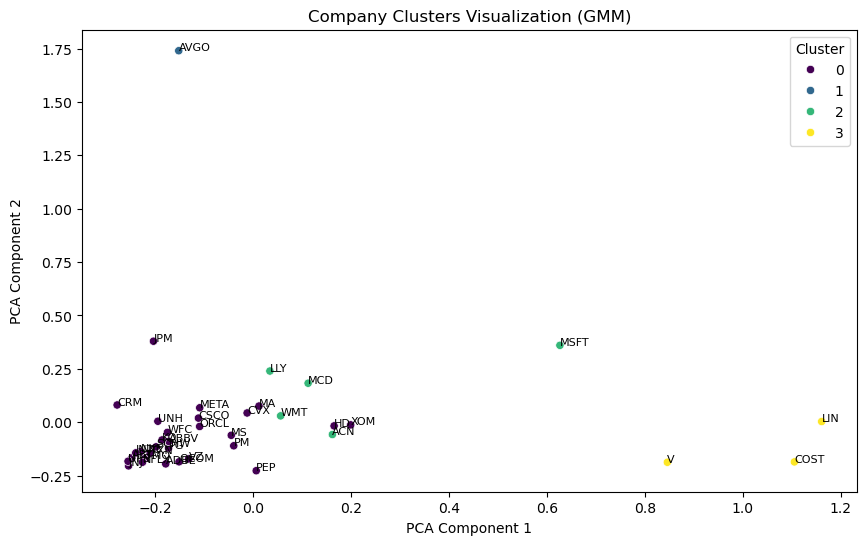

In [86]:
import pandas as pd
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

feature_vectors = feature_vectors_df.drop('Company', axis=1).values


n_components = 4  
gmm = GaussianMixture(n_components=n_components, random_state=0)
gmm.fit(feature_vectors)


feature_vectors_df['Cluster'] = gmm.predict(feature_vectors)

feature_vectors_2d = PCA(n_components=2).fit_transform(feature_vectors)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=feature_vectors_2d[:, 0], y=feature_vectors_2d[:, 1], hue=feature_vectors_df['Cluster'], palette='viridis')
for i, txt in enumerate(feature_vectors_df['Company']):
    plt.annotate(txt, (feature_vectors_2d[i, 0], feature_vectors_2d[i, 1]), fontsize=8)
plt.title('Company Clusters Visualization (GMM)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


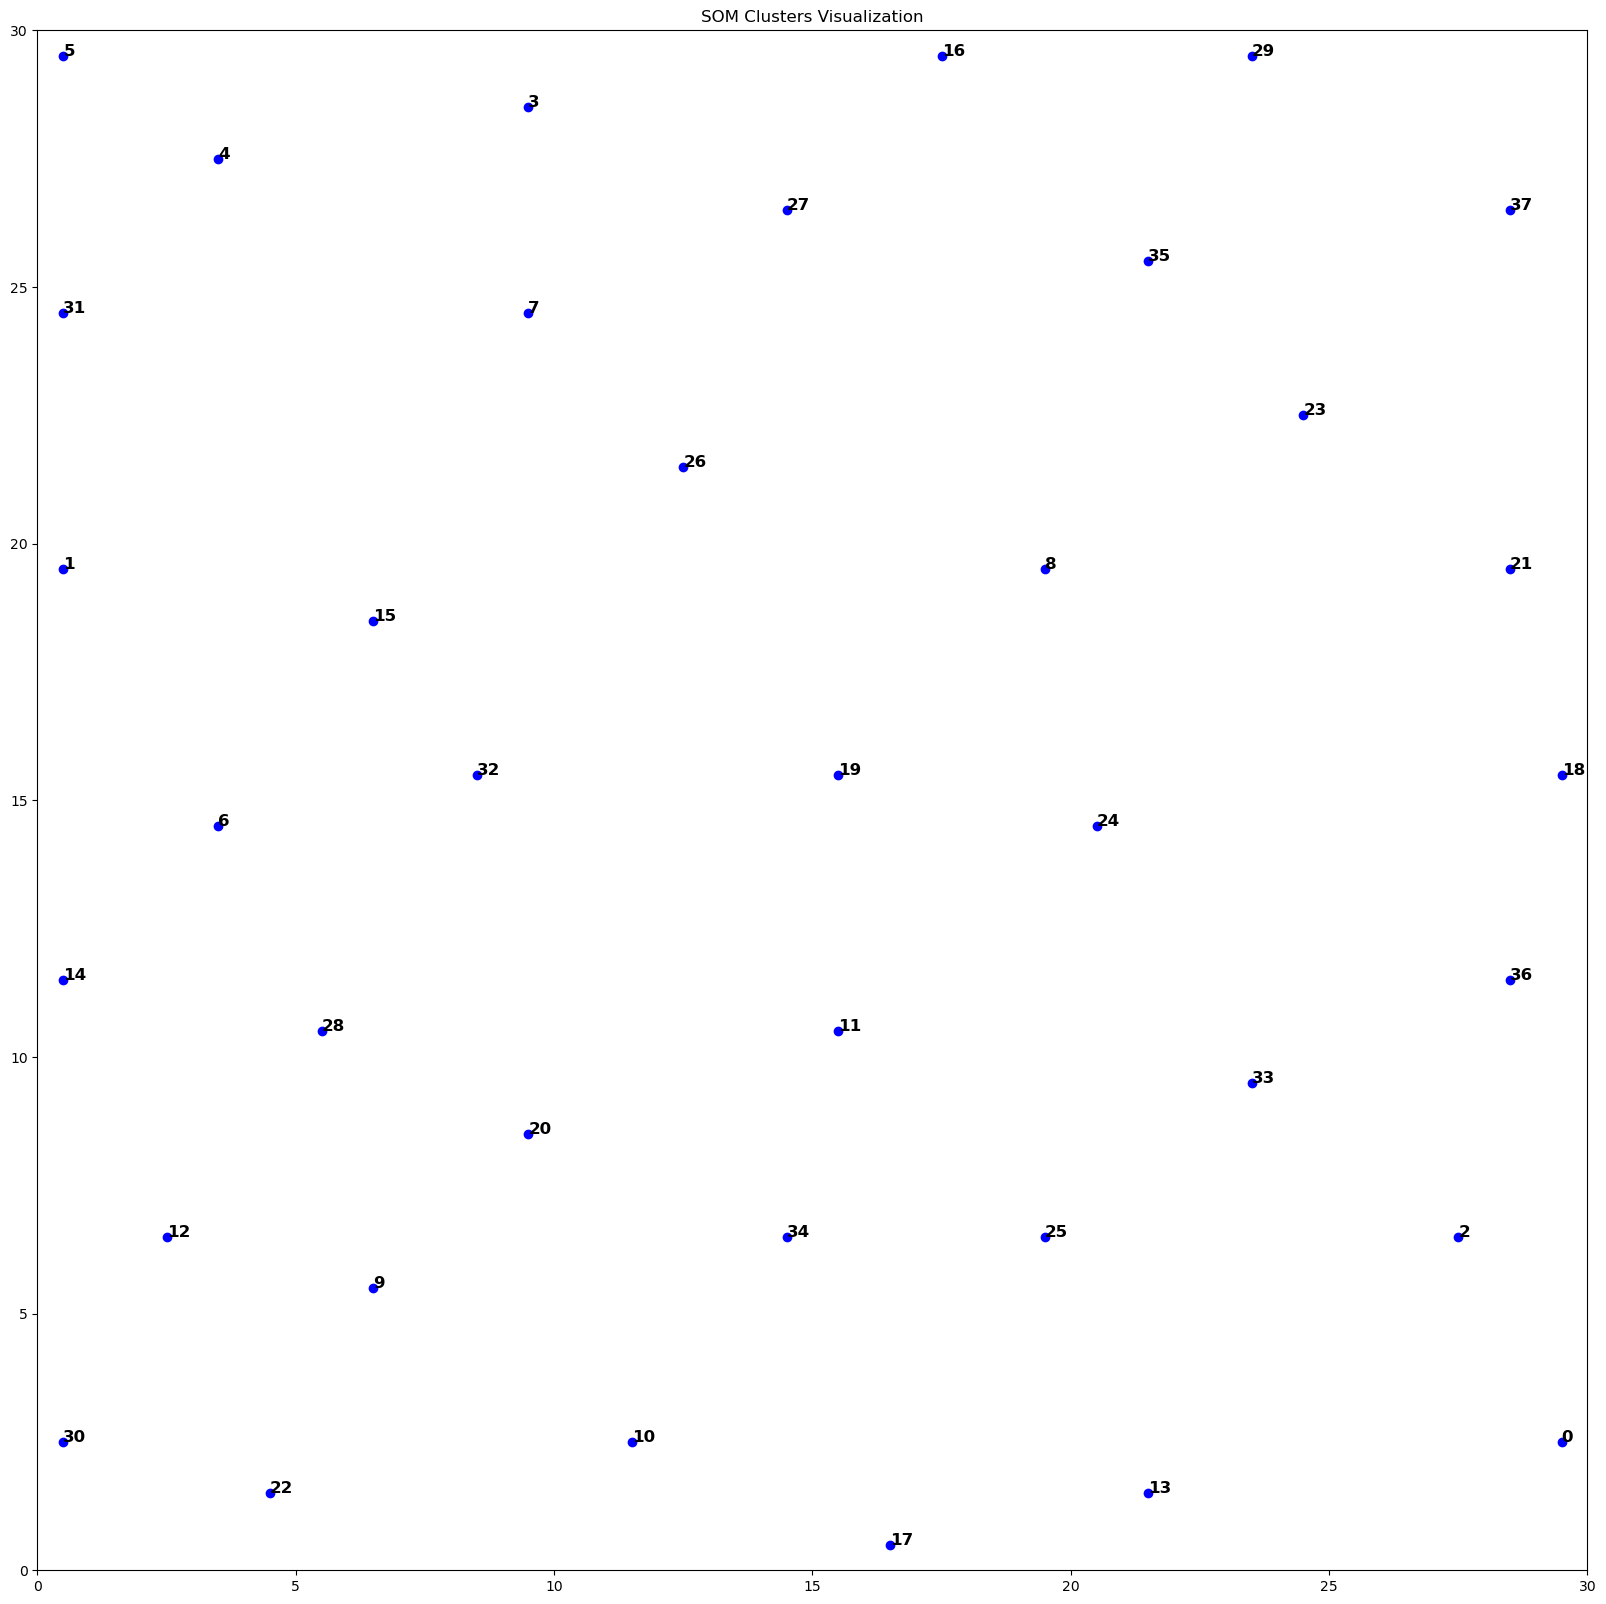

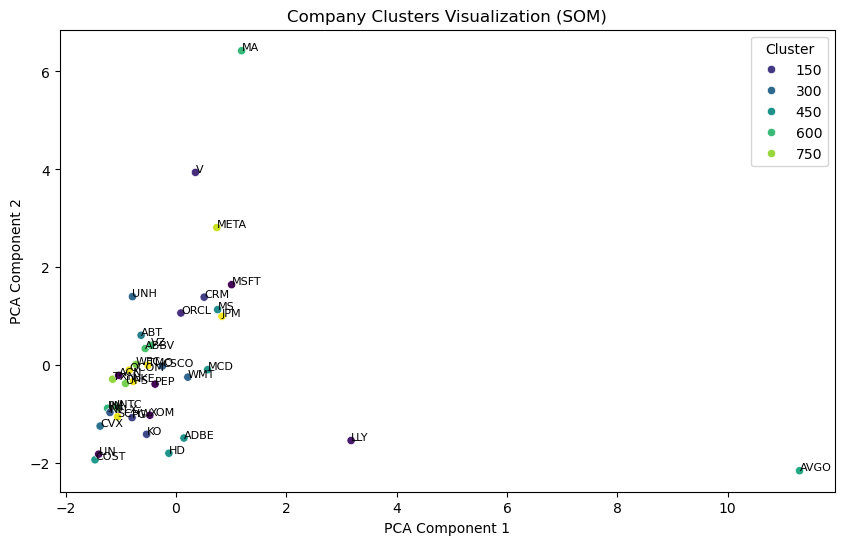

In [70]:
import pandas as pd
import numpy as np
from minisom import MiniSom
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


feature_vectors = feature_vectors_df.drop('Company', axis=1).values

scaler = StandardScaler()
feature_vectors = scaler.fit_transform(feature_vectors)

som_dim = (30, 30)  
som = MiniSom(som_dim[0], som_dim[1], feature_vectors.shape[1], sigma=0.7, learning_rate=0.3)
som.random_weights_init(feature_vectors)
som.train_random(feature_vectors, 10000)

win_map = som.win_map(feature_vectors)
clusters = np.zeros(len(feature_vectors))

for i, x in enumerate(feature_vectors):
    win_position = som.winner(x)
    clusters[i] = win_position[0] * som_dim[1] + win_position[1]  

feature_vectors_df['Cluster'] = clusters.astype(int)

plt.figure(figsize=(20, 20))
for i, (x, y) in enumerate(som.win_map(feature_vectors).keys()):
    plt.text(x + 0.5, y + 0.5, str(i), color='black', fontdict={'weight': 'bold', 'size': 12})
    plt.plot(x + 0.5, y + 0.5, 'bo')
plt.xlim([0, som_dim[0]])
plt.ylim([0, som_dim[1]])
plt.title('SOM Clusters Visualization')
plt.show()

from sklearn.decomposition import PCA

feature_vectors_2d = PCA(n_components=2).fit_transform(feature_vectors)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=feature_vectors_2d[:, 0], y=feature_vectors_2d[:, 1], hue=feature_vectors_df['Cluster'], palette='viridis')
for i, txt in enumerate(feature_vectors_df['Company']):
    plt.annotate(txt, (feature_vectors_2d[i, 0], feature_vectors_2d[i, 1]), fontsize=8)
plt.title('Company Clusters Visualization (SOM)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


In [71]:

for cluster in feature_vectors_df['Cluster'].unique():
    print(f"Cluster {cluster}:")
    print(feature_vectors_df[feature_vectors_df['Cluster'] == cluster]['Company'].values)
    print()


Cluster 872:
['JPM']

Cluster 19:
['MSFT']

Cluster 816:
['META']

Cluster 298:
['UNH']

Cluster 117:
['V']

Cluster 29:
['XOM']

Cluster 104:
['JNJ']

Cluster 294:
['WMT']

Cluster 589:
['MA']

Cluster 185:
['PG']

Cluster 332:
['CVX']

Cluster 460:
['HD']

Cluster 66:
['LLY']

Cluster 631:
['ABBV']

Cluster 11:
['PEP']

Cluster 198:
['KO']

Cluster 539:
['AVGO']

Cluster 480:
['COST']

Cluster 885:
['TMO']

Cluster 465:
['MCD']

Cluster 278:
['CSCO']

Cluster 859:
['NKE']

Cluster 121:
['ORCL']

Cluster 742:
['TXN']

Cluster 614:
['VZ']

Cluster 576:
['PM']

Cluster 381:
['ABT']

Cluster 446:
['ADBE']

Cluster 160:
['CRM']

Cluster 719:
['WFC']

Cluster 2:
['ACN']

Cluster 24:
['LIN']

Cluster 255:
['NFLX']

Cluster 699:
['UPS']

Cluster 426:
['MS']

Cluster 655:
['INTC']

Cluster 851:
['SCHW']

Cluster 866:
['QCOM']



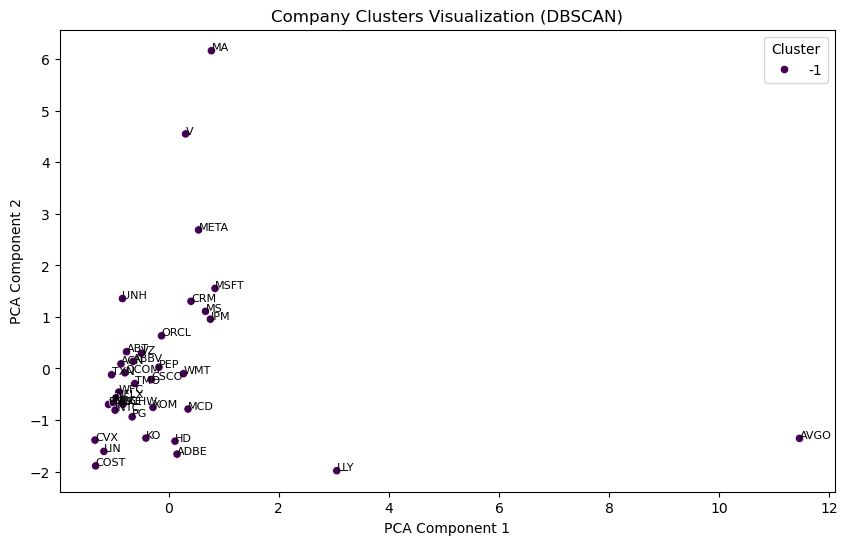

In [82]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

feature_vectors = feature_vectors_df.drop('Company', axis=1).values

scaler = StandardScaler()
feature_vectors_scaled = scaler.fit_transform(feature_vectors)

dbscan = DBSCAN(eps=5, min_samples=37)
dbscan.fit(feature_vectors_scaled)

feature_vectors_df['Cluster'] = dbscan.labels_

feature_vectors_2d = PCA(n_components=2).fit_transform(feature_vectors_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=feature_vectors_2d[:, 0], y=feature_vectors_2d[:, 1], hue=feature_vectors_df['Cluster'], palette='viridis')
for i, txt in enumerate(feature_vectors_df['Company']):
    plt.annotate(txt, (feature_vectors_2d[i, 0], feature_vectors_2d[i, 1]), fontsize=8)
plt.title('Company Clusters Visualization (DBSCAN)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


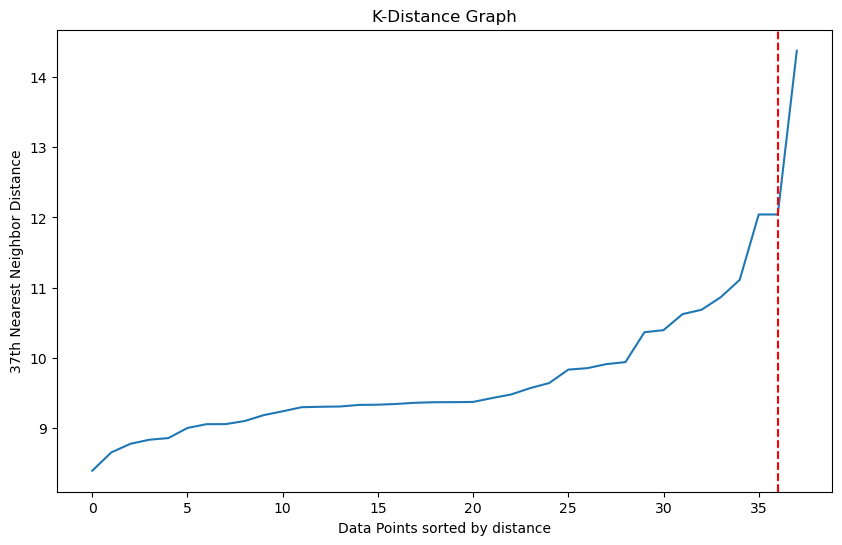

Suggested eps value: 12.042255420180886


In [79]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

feature_vectors = feature_vectors_df.drop('Company', axis=1).values

scaler = StandardScaler()
feature_vectors_scaled = scaler.fit_transform(feature_vectors)

k = 37  
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(feature_vectors_scaled)
distances, indices = nbrs.kneighbors(feature_vectors_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:, k-1]

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.axvline(x=np.argmax(np.diff(distances)), color='r', linestyle='--')
plt.title('K-Distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'{k}th Nearest Neighbor Distance')
plt.show()

eps = distances[np.argmax(np.diff(distances))]
print(f"Suggested eps value: {eps}")
